In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
import scipy.odr as odr
from photutils.isophote import EllipseGeometry,Ellipse,build_ellipse_model
from photutils.aperture import EllipticalAperture
import matplotlib as mpl
import scipy.ndimage as im

In [2]:
galaxies={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
SN_pos={'NGC3705': SkyCoord("11:30:05.940 +09:16:57.37",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:54.600 +30:16:17.40",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:04.895 +32:44:01.73",unit=('hourangle,deg')),
         'UGC9379': SkyCoord("14:33:57.009 +40:14:37.62",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57.173 +40:23:55.14",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44.400 +62:09:44.17",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:50.515 +12:41:44.20",unit=('hourangle,deg'))}


In [3]:
target='MCG05'
im_test=f'./WCS_Solved/{target}/{target}_R.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
gal_x_init,gal_y_init=wcs.world_to_pixel(galaxies[target])
sn_x,sn_y=wcs.world_to_pixel(SN_pos[target])

In [4]:
bkg = sep.Background(data)
data_sub=data-bkg.globalback
#objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True)
objects,seg_map = sep.extract(data_sub, 3, err=bkg.globalrms,segmentation_map=True,deblend_cont=1)#use if no blending wanted
dists=np.sqrt((objects['x']-gal_x_init)**2+(objects['y']-gal_y_init)**2)
obj=np.argmin(dists)
#print(objects[obj])
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
theta=objects['theta'][obj]
obj_seg=seg_map[int(y),int(x)]
bkg_mask=np.zeros(data.shape,dtype=bool)
masked_pixels=0
for i in range(len(data)):
    for j in range(len(data[i])):
        if seg_map[i][j]!=0:
            bkg_mask[i][j]=True
            masked_pixels+=1
newbkg=sep.Background(data,mask=bkg_mask)
bkg_mean,bkg_med,bkg_std=sigma_clipped_stats(newbkg,sigma=2)
print(bkg_mean,bkg_med,bkg_std)

492.5515190517809 492.6144104003906 1.2412809609271003


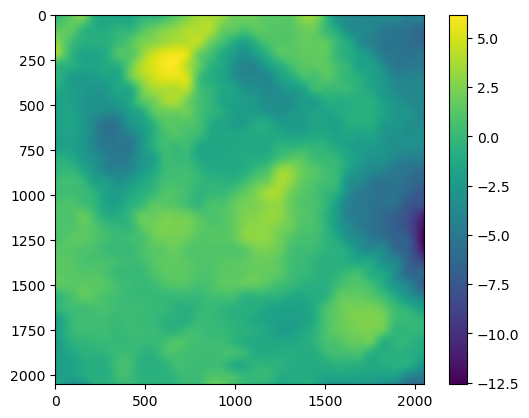

In [5]:
plt.imshow(newbkg.back()-bkg_med)
plt.colorbar()	

In [6]:
test=image.copy()
trues=0
for i in range(len(test)):
    for j in range(len(test[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            test[i][j]=bkg_med
            trues+=1
print(trues)

56343


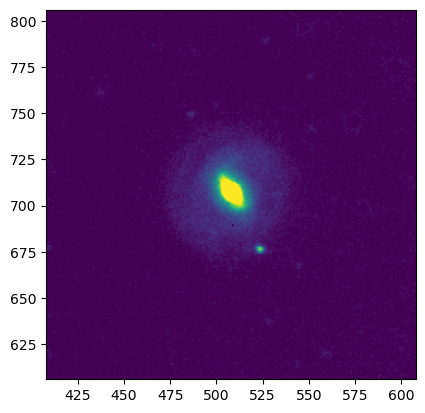

In [7]:
iso_data=test-bkg_med
plt.imshow(iso_data,vmin=0,vmax=500)
tol=100
plt.ylim(int(y)-tol,int(y)+tol)
plt.xlim(int(x)-tol,int(x)+tol)
geo=EllipseGeometry(x,y,a,np.sqrt(1-(b/a)**2),theta)
ellipse = Ellipse(iso_data, geo)
isos = ellipse.fit_image()
model_image = build_ellipse_model(iso_data.shape, isos)
residual = iso_data - model_image

[508.64522126 508.64522126 508.60286975 508.55176159 508.49625812
 508.47052141 508.4756467  508.46728329 508.45741245 508.45487987
 508.45114203 508.44781076 508.42377131 508.42552596 508.42232521
 508.42820412 508.41672711 508.41286577 508.39843466 508.37263657
 508.38309958 508.38466466 508.37775923 508.36977785 508.35770306
 508.36866831 508.37025482 508.36737171 508.38515066 508.37406862
 508.37406862 508.35049393 508.3449966  508.31856937 508.42468633
 508.55638338 508.34823625 508.26182551 508.16961008 508.04909902
 508.09997075 508.07423325 507.64659986 508.17921071 509.54902219
 507.25689047 507.25689047 508.20944    508.20944    508.20944   ]
203839.9284843292
508.3804294044516
(707, 509)


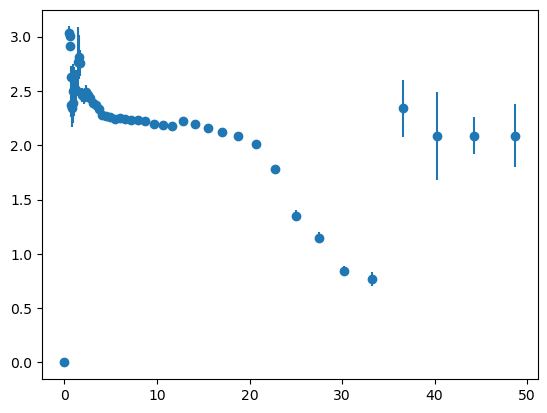

In [8]:
print(isos.x0)
print(0.5*np.nanmax(isos.tflux_e))
plt.errorbar(isos.sma,isos.pa,yerr=isos.pa_err,fmt='o')
print(np.median(isos.x0))
print(np.unravel_index(np.argmax(iso_data),iso_data.shape))

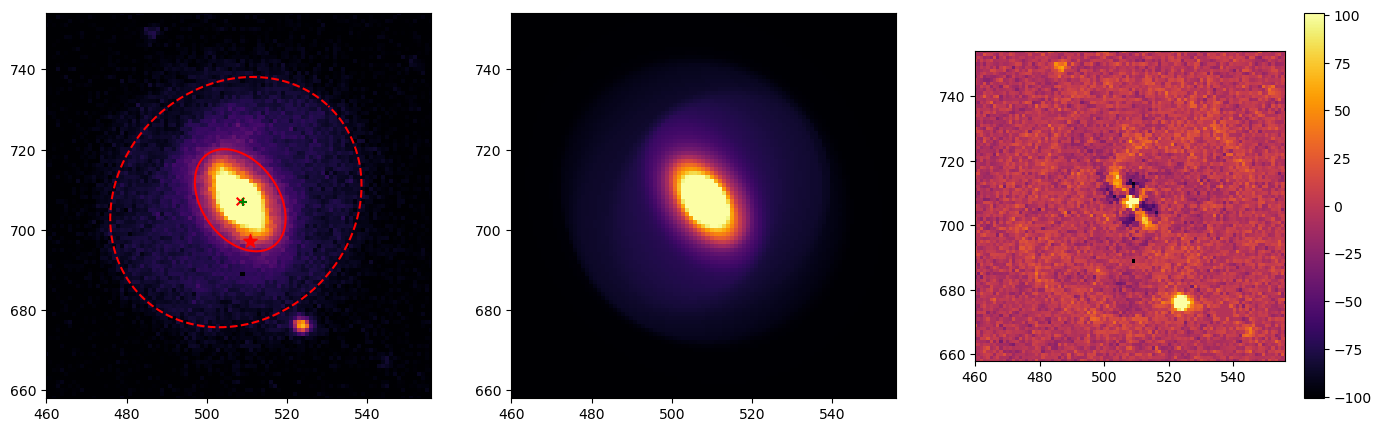

In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))
tol=int(1*np.max(isos.sma))
ax1.imshow(iso_data,vmin=0,vmax=500,cmap='inferno')
ax1.set_ylim(int(y)-tol,int(y)+tol)
ax1.set_xlim(int(x)-tol,int(x)+tol)
smas = np.linspace(np.min(isos.sma), np.max(isos.sma), 20)
half_flux=0.5*np.nanmax(isos.tflux_e)
iso_ind=np.nanargmin([np.abs(el-half_flux) for el in isos.tflux_e])
sma_r50=isos.sma[iso_ind]
iso_50=isos.get_closest(sma_r50)
x2,y2=iso_50.sampled_coordinates()
ax1.plot(x2,y2,color='r',zorder=10)
flux90=0.9*np.nanmax(isos.tflux_e)
iso_ind=np.nanargmin([np.abs(el-flux90) for el in isos.tflux_e])
sma_r90=isos.sma[iso_ind]
iso_90=isos.get_closest(sma_r90)
x2,y2=iso_90.sampled_coordinates()
ax1.plot(x2,y2,color='r',ls='--',zorder=10)
#iso=isos
ax2.imshow(model_image,vmin=0,vmax=500,cmap='inferno')
ax2.set_ylim(int(y)-tol,int(y)+tol)
ax2.set_xlim(int(x)-tol,int(x)+tol)
res_tol=10*sigma_clipped_stats(residual)[2]
ax3.imshow(residual,vmin=-res_tol,vmax=res_tol,cmap='inferno')
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=-res_tol, vmax=res_tol)
ax3.set_ylim(int(y)-tol,int(y)+tol)
ax3.set_xlim(int(x)-tol,int(x)+tol)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax3)
ax1.scatter(sn_x,sn_y,[100],marker='*',color='red')
ax1.scatter(np.median(isos.x0),np.median(isos.y0),[30],marker='x',color='red')
pix_max=np.unravel_index(np.argmax(iso_data),iso_data.shape)
ax1.scatter(pix_max[1],pix_max[0],[30],marker='+',color='green')


In [10]:
def Coord_Rotator(x,y,pa):
    x_rot=x*np.cos(pa*(np.pi/180))-y*np.sin(pa*(np.pi/180))
    y_rot=x*np.sin(pa*(np.pi/180))+y*np.cos(pa*(np.pi/180))
    return x_rot,y_rot
def Padded_Coord_Rotator(x,y,pa,padX,padY):
    x_new=x-padX[1]
    y_new=y-padY[1]
    x_rot=x_new*np.cos(pa*(np.pi/180))-y_new*np.sin(pa*(np.pi/180))
    y_rot=x_new*np.sin(pa*(np.pi/180))+y_new*np.cos(pa*(np.pi/180))
    x_rot+=padX[0]+padX[1]
    y_rot+=padY[0]+padY[1]
    return x_rot,y_rot
print(sn_x)

510.6696377370693


[1540, 508] [1347, 707]


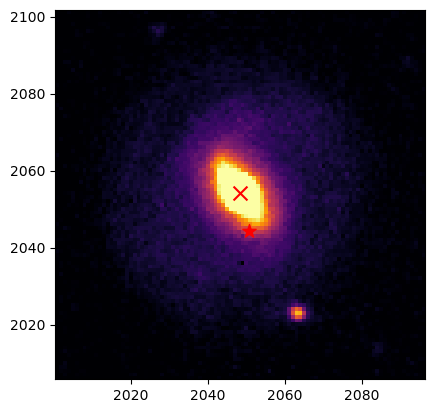

: 

In [13]:
pa=isos.pa[iso_ind]
padX = [iso_data.shape[1] - round(x), round(x)]
padY = [iso_data.shape[0] - round(y), round(y)]
print(padX,padY)
Padded = np.pad(iso_data, [padY, padX], 'constant')
rot_im=im.rotate(Padded,pa,reshape=False)
plt.imshow(rot_im,vmin=0,vmax=500,cmap='inferno')
plt.xlim(padX[0]+x-tol,padX[0]+x+tol)
plt.ylim(padY[0]+y-tol,padY[0]+y+tol)
plt.scatter(*Padded_Coord_Rotator(sn_x,sn_y,pa,padX,padY),[100],marker='*',color='red')
plt.scatter(*Padded_Coord_Rotator(np.median(isos.x0),np.median(isos.y0),pa,padX,padY),[100],marker='x',color='red')
#plt.scatter(*Coord_Rotator(sn_x,sn_y,pa),[100],marker='*',color='red')
#plt.scatter(*Coord_Rotator(np.median(isos.x0),np.median(isos.y0),pa),[30],marker='x',color='red')
# smas = np.linspace(np.min(isos.sma), np.max(isos.sma), 20)
# half_flux=0.5*np.nanmax(isos.tflux_e)
# iso_ind=np.nanargmin([np.abs(el-half_flux) for el in isos.tflux_e])
# sma_r50=isos.sma[iso_ind]
# iso_50=isos.get_closest(sma_r50)
# x2,y2=iso_50.sampled_coordinates()
# plt.plot(x2,y2,color='r',zorder=10)
# flux90=0.9*np.nanmax(isos.tflux_e)
# iso_ind=np.nanargmin([np.abs(el-flux90) for el in isos.tflux_e])
# sma_r90=isos.sma[iso_ind]
# iso_90=isos.get_closest(sma_r90)
# x2,y2=iso_90.sampled_coordinates()
# plt.plot(x2,y2,color='r',ls='--',zorder=10)